# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

## 70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，正解ラベルを並べた行列（ベクトル）Yを作成したい．・・・

In [1]:
import gensim

# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('../chapter07/data/GoogleNews-vectors-negative300.bin', binary=True)
print('vocab size:', len(model.vocab))
print('vec dim:', model['United_States'].shape)

vocab size: 3000000
vec dim: (300,)


In [1]:
from logzero import logger
from tqdm import tqdm
import numpy as np
import nltk
nltk.download('punkt')  # 英語単語分割に使用

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/y_kishinami/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# ファイルのデータを記事見出しとカテゴリに分割する関数
def split_data(file_path:str) -> (np.ndarray, np.ndarray):
    titles, categories = [],[]
    with open(file_path) as fi:
        for line in fi:
            title, category = line.strip().split('\t')
            titles.append(title)
            categories.append(category)
    return np.array(titles),np.array(categories)


#  記事見出しを各文章のベクトル（文章内の単語の平均ベクトル(numpy配列))に変換する関数
def title2average_vec(titles: np.ndarray) -> np.ndarray:
    vec_list = []
    for title in titles:
        vec, count = np.zeros(300), 0  # ３００次元なので
        words = nltk.word_tokenize(title)
        for word in words:
            try:
                vec += model[word]
                count += 1
            except KeyError:
                pass
        if count == 0:
            logger.warning('titleが空文字になっているデータが含まれています')
            continue

        vec_list.append(vec / count)  # 単語ベクトルの平均
    return np.array(vec_list)


# カテゴリーから数値データに変換
def category2num(categories: np.ndarray) -> np.ndarray:
    category_dic = {'b':0,'t':1,'e':2,'m':3}
    return np.array([category_dic[category] for category in categories])

In [10]:
name_list = ['train','valid','test']  # ファイル名用のリスト

# 各データについてデータを保存
for name in name_list:
    titles, categories = split_data('/Users/y_kishinami/Documents/100knock-2020/y-kishinami/chapter06/work/' + name + '.txt')
    vec_list, label_list = title2average_vec(titles), category2num(categories)
    np.save('work/' + name + '_x', vec_list)
    np.save('work/' + name + '_y', label_list)
    logger.info('{} data shape  x : {} y : {}'.format(name, vec_list.shape, label_list.shape))

[I 201121 13:58:48 <ipython-input-10-dcb3db7c7f4f>:9] train data shape  x : (10684, 300) y : (10684,)
[I 201121 13:58:49 <ipython-input-10-dcb3db7c7f4f>:9] valid data shape  x : (1336, 300) y : (1336,)
[I 201121 13:58:49 <ipython-input-10-dcb3db7c7f4f>:9] test data shape  x : (1336, 300) y : (1336,)


## 71. 単層ニューラルネットワークによる予測

In [2]:
import torch  # 基本モジュール
import torch.nn as nn  # network構築
import torch.nn.functional as F  # network用の関数
import torch.optim as optim
import numpy as np
from tqdm import tqdm

In [3]:
# データの読み込みとtensorへの変換
def load_file(path:str) -> np.ndarray:
    data = np.load(path).astype(np.float32)
    return torch.from_numpy(data)

In [4]:
# 読み込み
x_train, y_train = load_file('work/train_x.npy'), load_file('work/train_y.npy').type(torch.long)
x_valid, y_valid = load_file('work/valid_x.npy'), load_file('work/valid_y.npy').type(torch.long)
x_test, y_test = load_file('work/test_x.npy'), load_file('work/test_y.npy').type(torch.long)
x_train.shape

torch.Size([10684, 300])

#### 解法1：ネットワークのクラスを定義しない

In [5]:
W = torch.randn(300,4, requires_grad=True)  # requires_gradは指定のtensorを微分対象にするかどうか。Falseだと勾配にNoneが返る
print(x_train[:1].shape)
print(torch.matmul(x_train[:1],W).shape)
print(F.softmax(torch.matmul(x_train[:1],W),dim=-1))  # 今回の場合dim=0はおかしい　かつ　-1と1は同じ次元を表す
print(F.softmax(torch.matmul(x_train[:4],W),dim=-1))

torch.Size([1, 300])
torch.Size([1, 4])
tensor([[0.7546, 0.0182, 0.0106, 0.2167]], grad_fn=<SoftmaxBackward>)
tensor([[0.7546, 0.0182, 0.0106, 0.2167],
        [0.2920, 0.6939, 0.0094, 0.0047],
        [0.6611, 0.0211, 0.0395, 0.2784],
        [0.2317, 0.1032, 0.4077, 0.2574]], grad_fn=<SoftmaxBackward>)


In [6]:
# 次元の指定は、配列の指定の仕方でも変わるね
print(x_train[0].shape)
print(torch.matmul(x_train[0],W).shape)
print(F.softmax(torch.matmul(x_train[0],W),dim=0))
print(torch.sum(F.softmax(torch.matmul(x_train[0],W),dim=0)))  # ちゃんと合計が1になっている

torch.Size([300])
torch.Size([4])
tensor([0.7546, 0.0182, 0.0106, 0.2167], grad_fn=<SoftmaxBackward>)
tensor(1.0000, grad_fn=<SumBackward0>)


#### 解法2：ネットワークをクラスで定義

In [5]:
class Net(nn.Module):  # nn.Moduleクラスの継承
    def __init__(self):
        super(Net,self).__init__()  # nn.Moduleクラスの初期化関数を起動
        self.fc1 = nn.Linear(300, 4, bias=False)  # y = wx 300は入力サイズ、4は出力サイズ bias=Falseにすればy=wxになるね
        #nn.init.normal_(self.fc1.weight, 0.0, 1.0) # 重みの初期化　正規分布
    
    def forward(self,x):
        x = self.fc1(x)
        return x

In [7]:
# モデル定義
net = Net()
print(F.softmax(net(x_train[:1]), dim=-1))
print(F.softmax(net(x_train[:4]), dim=-1))

tensor([[0.2633, 0.2312, 0.2593, 0.2462]], grad_fn=<SoftmaxBackward>)
tensor([[0.2633, 0.2312, 0.2593, 0.2462],
        [0.2505, 0.2553, 0.2559, 0.2384],
        [0.2489, 0.2276, 0.2592, 0.2643],
        [0.2515, 0.2432, 0.2590, 0.2462]], grad_fn=<SoftmaxBackward>)


https://blog.snowhork.com/2018/11/pytorch-initialize-weight

パラメータについて
https://qiita.com/mathlive/items/d9f31f8538e20a102e14

入門
https://qiita.com/sh-tatsuno/items/42fccff90c98103dffc9

https://qiita.com/mocobt/items/dd2e60fa2909bfa93b06


## 72. 損失と勾配の計算

In [9]:
# Loss関数の指定
criterion = nn.CrossEntropyLoss()
output = net(x_train[:1])
loss = criterion(output, y_train[:1])  # x_train[0]の形式をうけつけちゃダメ  softmaxをやる前のやつを入れちゃだめ

net.zero_grad()  # 勾配の初期化　これ忘れると繰り返すときにどんどん溜まっていく
loss.backward()  # 逆伝播

print(loss)   # loss
print(net.fc1.weight.grad)  # 勾配

tensor(1.3705, grad_fn=<NllLossBackward>)
tensor([[-0.0645,  0.0085,  0.0077,  ...,  0.0412, -0.0431,  0.0075],
        [ 0.0225, -0.0030, -0.0027,  ..., -0.0143,  0.0150, -0.0026],
        [ 0.0197, -0.0026, -0.0024,  ..., -0.0126,  0.0132, -0.0023],
        [ 0.0224, -0.0030, -0.0027,  ..., -0.0143,  0.0149, -0.0026]])


In [10]:
output2 = net(x_train[:4])
loss2 = criterion(output2, y_train[:4])

net.zero_grad()
loss2.backward()

print(loss2)
print(net.fc1.weight.grad)

tensor(1.3515, grad_fn=<NllLossBackward>)
tensor([[-0.0308, -0.0094,  0.0132,  ...,  0.0013, -0.0218,  0.0214],
        [ 0.0175,  0.0027, -0.0124,  ...,  0.0033,  0.0180, -0.0112],
        [-0.0043,  0.0040,  0.0118,  ..., -0.0080, -0.0145,  0.0011],
        [ 0.0176,  0.0027, -0.0126,  ...,  0.0034,  0.0183, -0.0113]])


#### zero_gradがどういう働きをしているか

In [10]:
for i in range(1000):
    loss = criterion(net(x_train[:1]), y_train[:1])
    net.zero_grad()
    loss.backward()
print('zero_gradあり')
print(net.fc1.weight.grad)

for i in range(1000):
    loss = criterion(net(x_train[:1]), y_train[:1])
    #net.zero_grad()
    loss.backward()
print('zero_gradなし')
print(net.fc1.weight.grad)

zero_gradあり
tensor([[-0.0652,  0.0086,  0.0078,  ...,  0.0416, -0.0436,  0.0075],
        [ 0.0205, -0.0027, -0.0025,  ..., -0.0131,  0.0137, -0.0024],
        [ 0.0220, -0.0029, -0.0026,  ..., -0.0140,  0.0147, -0.0025],
        [ 0.0228, -0.0030, -0.0027,  ..., -0.0145,  0.0152, -0.0026]])
zero_gradなし
tensor([[-65.3090,   8.6322,   7.8027,  ...,  41.6482, -43.6216,   7.5416],
        [ 20.5373,  -2.7145,  -2.4536,  ..., -13.0966,  13.7171,  -2.3715],
        [ 21.9838,  -2.9057,  -2.6265,  ..., -14.0190,  14.6834,  -2.5386],
        [ 22.7887,  -3.0120,  -2.7226,  ..., -14.5323,  15.2208,  -2.6315]])


## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [11]:
# モデルの初期化と各種設定
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)  # 学習率は0.001とする
epoch_size = 100  # epoch数

In [9]:
dataset = torch.utils.data.TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, shuffle=True)

In [12]:
train_loss = []  # lossの格納用

dataset = torch.utils.data.TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset, shuffle=True)
data_size = len(x_train)

# train
for epoch in tqdm(range(epoch_size)):
    running_loss = 0.0
    
    for inputs,labels in data_loader:  # 訓練データ数
        optimizer.zero_grad()  # optimizerの初期化
        
        loss = criterion(net(inputs), labels)  # lossの計算
        loss.backward()  # 逆伝播
        optimizer.step()  # parameterの更新
        running_loss += loss.item()
        
    loss = running_loss / data_size
    train_loss.append(loss)
    
    # 経過の表示用
    if (epoch+1) % 10 == 0:
        logger.info("epoch {} : done loss : {}".format(epoch+1, loss))

logger.info('finished training')

100%|██████████| 100/100 [05:09<00:00,  3.09s/it]
[I 201127 16:25:41 <ipython-input-12-26014a02fbb8>:26] finished training


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [6]:
from sklearn.metrics import accuracy_score
def accuracy(net, x_train, y_train):
    return accuracy_score(torch.argmax(F.softmax(net(x_train), dim=-1), dim=-1), y_train)

In [ ]:
print("train accuracy : {}".format(accuracy_score(torch.argmax(F.softmax(net(x_train), dim=-1), dim=-1), y_train)
print("train accuracy : {}".format(accuracy_score(torch.argmax(F.softmax(net(x_valid), dim=-1), dim=-1), y_valid)
print("train accuracy : {}".format(accuracy_score(torch.argmax(F.softmax(net(x_test), dim=-1)), dim=-1), y_test)

## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [7]:
# lossの計算用
def loss_calc(net, x, y):
    return criterion(net(x), y).item()

In [8]:
# train用
def train(net, criterion, optimizer, epoch_size, batch_size):

    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    train_acc, valid_acc, train_loss, valid_loss = [], [], [], []
    data_size = len(dataset)
    
    # train
    logger.info('training start!')
    for epoch in tqdm(range(epoch_size)):
        running_loss = 0.0
        for inputs, labels in data_loader:  # 訓練データ数
            optimizer.zero_grad()  # optimizerの初期化

            loss = criterion(net(inputs), labels)  # lossの計算
            loss.backward()  # 逆伝播
            optimizer.step()  # parameterの更新
            running_loss += loss.item()
        
        train_acc.append(accuracy(net, x_train, y_train))
        train_loss.append(running_loss / len(data_loader))
        valid_acc.append(accuracy(net, x_valid, y_valid))
        valid_loss.append(loss_calc(net, x_valid, y_valid))
        
        # 経過の表示用
        if (epoch+1) % 10 == 0:
            logger.info("epoch {} : done loss : {}".format(epoch+1, loss))
            
    logger.info('finished training')
    return train_acc, valid_acc, train_loss, valid_loss

In [60]:
# モデルの初期化
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epoch_size = 100
batch_size = 1
# 学習
train_acc,valid_acc,train_loss,valid_loss = train(net, criterion, optimizer, epoch_size, batch_size)

[I 201121 18:01:06 <ipython-input-59-df0b9624dc10>:10] training start!
100%|██████████| 100/100 [06:42<00:00,  4.02s/it]
[I 201121 18:07:48 <ipython-input-59-df0b9624dc10>:31] finished training


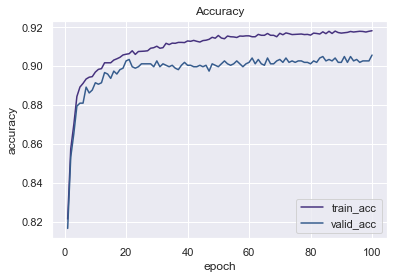

In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette('viridis')

# 正解率の表示
fig, ax = plt.subplots()
x = np.arange(1, epoch_size+1)
ax.plot(x,np.array(train_acc), label='train_acc')
ax.plot(x,np.array(valid_acc), label='valid_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
ax.legend()

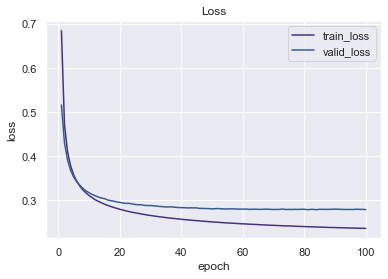

In [68]:
# lossの表示
#loss_graph(epoch_size,train_loss,valid_loss)
fig,ax = plt.subplots()
x = np.arange(1, epoch_size+1)
ax.plot(x,np.array(train_loss), label='train_loss')
ax.plot(x,np.array(valid_loss), label='valid_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")
ax.legend()

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [9]:
# モデルの状態と最適化アルゴリズムの内部状態を保存する関数
def save(net, epoch, optimizer):
    path = f'work/model/checkpoint{epoch}.pth'
    torch.save({
        'epoch':epoch,
        'model_state_dict':net.state_dict(),
        'optimizer_state_dict':optimizer.state_dict()
    }, path)
    logger.info('save checkpoint:{}'.format(epoch))

In [60]:
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
dataset = torch.utils.data.TensorDataset(x_train, y_train)
data_loader = torch.utils.data.DataLoader(dataset)
epoch_size = 10  # epoch数
train_acc, valid_acc, train_loss, valid_loss = [], [], [], []
data_size = len(x_train)


# train
logger.info('training start!')
for epoch in tqdm(range(epoch_size)):
    running_loss = 0.0
    for inputs,labels in data_loader:  # 訓練データ数
        optimizer.zero_grad()  # optimizerの初期化
        
        loss = criterion(net(inputs), labels)  # lossの計算
        loss.backward()  # 逆伝播
        optimizer.step()  # parameterの更新
        running_loss += loss.item()
    
    with torch.no_grad():
        train_acc.append(accuracy(net, x_train, y_train))
        valid_acc.append(accuracy(net, x_valid, y_valid))
        valid_loss.append(loss_calc(net, x_valid, y_valid))
        train_loss.append(running_loss / data_size)
    save(net, epoch+1, optimizer)  # 状態の保存
    
logger.info('finished training')

[I 201211 14:14:29 <ipython-input-60-ccfc60bf5de3>:12] training start!
100%|██████████| 10/10 [00:22<00:00,  2.28s/it]
[I 201211 14:14:52 <ipython-input-60-ccfc60bf5de3>:30] finished training


In [61]:
# fileがちゃんとできているか
!ls work/model

checkpoint1.pth   checkpoint3.pth  checkpoint6.pth  checkpoint9.pth
checkpoint10.pth  checkpoint4.pth  checkpoint7.pth  checkpointbest.pth
checkpoint2.pth   checkpoint5.pth  checkpoint8.pth


In [62]:
# 中身をみてみる
!head work/model/checkpoint1.pth

PK                    archive/data.pklFB ZZZZZZZZZZZZZZ�}q (X   epochqKX   model_state_dictqccollections
OrderedDict
q)RqX
   fc1.weightqctorch._utils
_rebuild_tensor_v2
q((X   storageqctorch
FloatStorage
X   140199468497904q	X   cpuq
�h)RqtqRqs}qX	   _metadataqh)Rq(X    q}qX   versionqKsX   fc1q}qhKsusbX   optimizer_state_dictq}q(X   stateq}qX   param_groupsq]q}q(X   lrq G?�z�G�{   momentumq!K X	   dampeningq"K X   weight_decayq#K    nesterovq$�X   paramsq%]q&K auauu.PK�C�E�  �  PK                    archive/data/140199468497904FB ZZZ�}X�Hٴ��
Ҿ�c���ݤ���9>��8��%�����>0�����=�s�>��X�<�	ʾ�.�>���>\�žl���먽1ݶ���ͼ�$>DO�	UE>��)��ڲ>P(=�Z[�Yʾ��>�^8>��>��e����L3	?��pi�'�*���:��(?B�>�ر>H


## 77. ミニバッチ化
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [22]:
# モデル　損失関数　最適化アルゴリズム
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.01)

In [25]:
%%time
# 第5引数がバッチサイズになるように関数を定義しておいた
train(net,criterion,optimizer,1,1)

[I 201202 22:31:52 <ipython-input-24-910539e4656f>:10] training start!
100%|██████████| 1/1 [00:02<00:00,  2.40s/it]
[I 201202 22:31:55 <ipython-input-24-910539e4656f>:30] finished training


CPU times: user 2.31 s, sys: 18.3 ms, total: 2.33 s
Wall time: 2.41 s


([0.8128041931860727],
 [0.813622754491018],
 [0.6820162814985703],
 [0.5199757218360901])

In [26]:
%%time
train(net,criterion,optimizer,1,2)

[I 201202 22:32:30 <ipython-input-24-910539e4656f>:10] training start!
100%|██████████| 1/1 [00:01<00:00,  1.69s/it]
[I 201202 22:32:31 <ipython-input-24-910539e4656f>:30] finished training


CPU times: user 1.6 s, sys: 15.4 ms, total: 1.62 s
Wall time: 1.7 s


([0.845282665668289],
 [0.8420658682634731],
 [0.49100882704263377],
 [0.4635029435157776])

In [27]:
%%time
train(net,criterion,optimizer,1,4)

[I 201202 22:32:36 <ipython-input-24-910539e4656f>:10] training start!
100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
[I 201202 22:32:37 <ipython-input-24-910539e4656f>:30] finished training


CPU times: user 798 ms, sys: 10.6 ms, total: 808 ms
Wall time: 851 ms


([0.8524897042306252],
 [0.8495508982035929],
 [0.45590569985976764],
 [0.44552743434906006])

In [28]:
%%time
train(net,criterion,optimizer,1,8)

[I 201202 22:32:41 <ipython-input-24-910539e4656f>:10] training start!
100%|██████████| 1/1 [00:00<00:00,  1.37it/s]
[I 201202 22:32:42 <ipython-input-24-910539e4656f>:30] finished training


CPU times: user 577 ms, sys: 9.91 ms, total: 587 ms
Wall time: 736 ms


([0.8561400224634969],
 [0.8495508982035929],
 [0.442390330041017],
 [0.437753289937973])

バッチサイズを大きくするごとに時間は短くなっていることがわかる

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [58]:
!python src/train.py --train-pref work/train --valid-pref work/valid --batch 16 --epoch 100 --lr 0.01

cpu
[I 201210 22:17:21 train:93] Namespace(batch=16, epoch=100, lr=0.01, train_pref='work/train', valid_pref='work/valid')
[I 201210 22:17:22 train:62] training start!
[I 201210 22:17:27 train:85] epoch 10 : done.
[I 201210 22:17:27 train:86] train acc:0.791183077499064	train loss:0.5877251029014587
[I 201210 22:17:27 train:87] valid acc:0.7896706586826348	valid loss:0.5859682559967041
[I 201210 22:17:30 train:85] epoch 20 : done.
[I 201210 22:17:30 train:86] train acc:0.83508049419693	train loss:0.48786452412605286
[I 201210 22:17:30 train:87] valid acc:0.8308383233532934	valid loss:0.487003356218338
[I 201210 22:17:33 train:85] epoch 30 : done.
[I 201210 22:17:33 train:86] train acc:0.8567952077873455	train loss:0.43751317262649536
[I 201210 22:17:33 train:87] valid acc:0.8495508982035929	valid loss:0.43786224722862244
[I 201210 22:17:36 train:85] epoch 40 : done.
[I 201210 22:17:36 train:86] train acc:0.8678397603893673	train loss:0.40648481249809265
[I 201210 22:17:36 train:87] val

- gpuでの学習時間：28秒
- cpuでの学習時間：44秒
     - モデルの規模が大きくないのでGPUでやってもあまり変わらない？

## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [63]:
# 学習コードの改良
def train_hypersearch(net, criterion, optimizer, epoch_size, batch_size, path):

    dataset = torch.utils.data.TensorDataset(x_train, y_train)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    train_acc, valid_acc, train_loss, valid_loss = [], [], [], []
    data_size = len(dataset)
    best_acc = 0
    
    # train
    logger.info('training start!')
    for epoch in range(epoch_size):
        running_loss = 0.0
        for inputs, labels in data_loader:  # 訓練データ数
            optimizer.zero_grad()  # optimizerの初期化

            loss = criterion(net(inputs), labels)  # lossの計算
            loss.backward()  # 逆伝播
            optimizer.step()  # parameterの更新
            running_loss += loss.item()
        
        with torch.no_grad():
            train_acc, train_loss = accuracy(net, x_train, y_train), running_loss / len(data_loader)
            valid_acc, valid_loss = accuracy(net, x_valid, y_valid), loss_calc(net, x_valid, y_valid)
        
        # 経過の表示用
        if (epoch+1) % 10 == 0:
            print("epoch {} done.".format(epoch+1))
            print("train accuracy: {}\tvalid loss: {}".format(train_acc, train_loss))
            print("valid accuracy: {}\tvalid loss: {}".format(valid_acc, valid_loss))
            
        # validのaccの最大値が更新されたらそのチェックポイントを保存
        if best_acc <= valid_acc:
            best_acc = valid_acc
            torch.save({
                'epoch':epoch,
                'model_state_dict':net.state_dict(),
                'optimizer_state_dict':optimizer.state_dict()
            }, path)
            print("save checkpoint epoch : {} acc : {}".format(epoch+1, valid_acc))
            
    logger.info('finished training')

In [64]:
# 多層化

class NN(nn.Module):  # nn.Moduleクラスの継承
    def __init__(self,input_size,hidden_size,output_size):
        super(NN,self).__init__()  # nn.Moduleクラスの初期化関数を起動
        # y = wx+b
        self.fc1 = nn.Linear(input_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # ドロップアウト確率0.2
        nn.init.kaiming_normal_(self.fc1.weight)  # Heの初期値みたいな
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self,x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [100]:
nn_net = NN(300,128,4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_net.parameters())
epoch_size = 100
batch_size = 64
path = f'work/model/checkpointbest.pth'
train_hypersearch(nn_net,criterion,optimizer,epoch_size,batch_size, path)

[I 201211 14:26:49 <ipython-input-63-eac793633188>:11] training start!


save checkpoint epoch : 1 acc : 0.8667664670658682
save checkpoint epoch : 2 acc : 0.8824850299401198
save checkpoint epoch : 3 acc : 0.8892215568862275
save checkpoint epoch : 4 acc : 0.8974550898203593
save checkpoint epoch : 5 acc : 0.8982035928143712
save checkpoint epoch : 6 acc : 0.9011976047904192
save checkpoint epoch : 9 acc : 0.9034431137724551
epoch 10 done.
train accuracy: 0.9254960688880569	valid loss: 0.22108557748937321
valid accuracy: 0.9049401197604791	valid loss: 0.27515965700149536
save checkpoint epoch : 10 acc : 0.9049401197604791
save checkpoint epoch : 12 acc : 0.9079341317365269
save checkpoint epoch : 15 acc : 0.9101796407185628
save checkpoint epoch : 18 acc : 0.9101796407185628
epoch 20 done.
train accuracy: 0.9476787719955073	valid loss: 0.16263505412700646
valid accuracy: 0.9086826347305389	valid loss: 0.2687368094921112
save checkpoint epoch : 21 acc : 0.9101796407185628
save checkpoint epoch : 26 acc : 0.9109281437125748
epoch 30 done.
train accuracy: 0.9

[I 201211 14:27:24 <ipython-input-63-eac793633188>:42] finished training


epoch 100 done.
train accuracy: 0.9982216398352677	valid loss: 0.011048670695023891
valid accuracy: 0.9116766467065869	valid loss: 0.4548371434211731


In [101]:
# チェックポイントのロード
best_net = NN(300,128,4)
checkpoint = torch.load('work/model/checkpointbest.pth')
best_net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [106]:
# テストデータでの正解率
accuracy_score(torch.argmax(F.softmax(best_net(x_test), dim=-1), dim=-1), y_test)

0.9109281437125748

## 多層ニューラルネットワークの実験まとめ
- 中間層1つ 300->128->ReLU,dropout->128->4　エポック数100　バッチサイズ8　ドロップアウト確率0.2　
- 損失関数：クロスエントロピー　最適化アルゴリズム：SGD(学習率0.001)
 - 正解率　訓練データ：0.9444756554307117　検証データ：0.9235955056179775


- 中間層1つ 300->128->ReLU,dropout->128->4　エポック数100　バッチサイズ4　ドロップアウト確率0.2　
- 損失関数：クロスエントロピー　最適化アルゴリズム：SGD(学習率0.001)
 - 正解率　訓練データ：0.972565543071161　検証データ：0.9176029962546817
 

- 中間層1つ 300->128->ReLU,dropout->128->4　エポック数100　バッチサイズ1　ドロップアウト確率0.2　
- 損失関数：クロスエントロピー　最適化アルゴリズム：SGD(学習率0.001)
 - 正解率　訓練データ：0.9973782771535581　検証データ：0.9131086142322098